AUTOENCODER REGULARIZADO

Epoch 1/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0740 - val_loss: 0.0283
Epoch 2/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0333 - val_loss: 0.0250
Epoch 3/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0304 - val_loss: 0.0239
Epoch 4/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0292 - val_loss: 0.0231
Epoch 5/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0284 - val_loss: 0.0224
Epoch 6/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0278 - val_loss: 0.0219
Epoch 7/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0275 - val_loss: 0.0215
Epoch 8/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0271 - val_loss: 0.0212
Epoch 9/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0267 - val_loss: 0.0211
Epoch 10/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0266 - val_loss: 0.0207
Epoch 11/100
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0263 - val_loss: 0.0208
Epoch 12/100
469/469 ━━━━━━━━━━━━━━━━━━

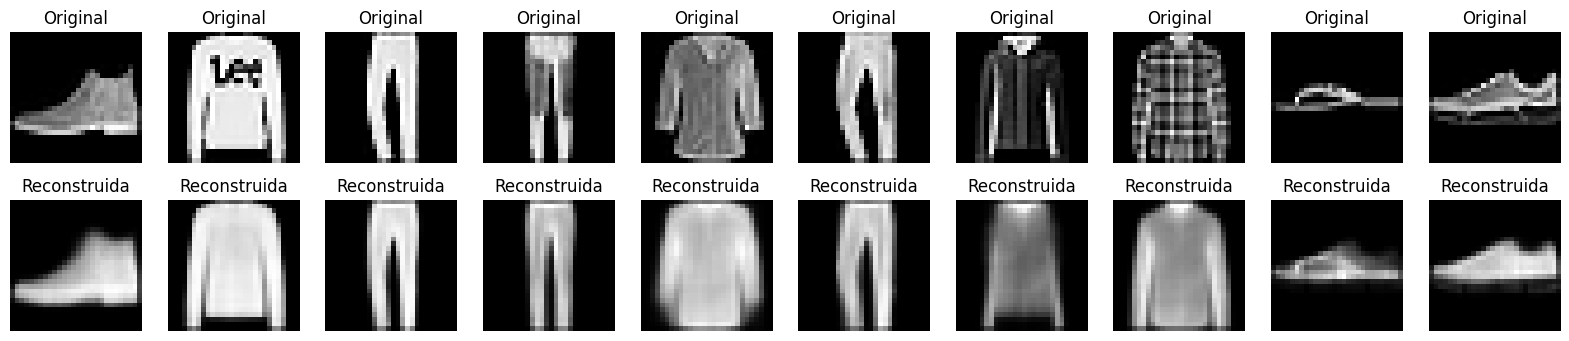

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


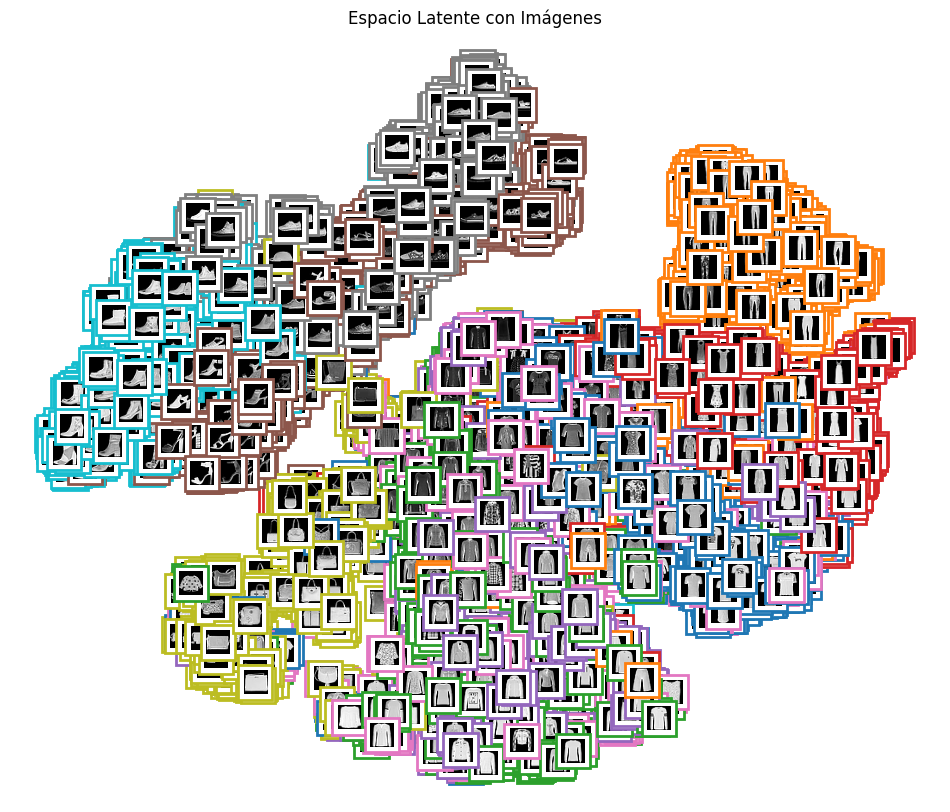

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from keras.datasets import fashion_mnist
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# ----------------------------------------------------------------------
# Cargar y preprocesar los datos de Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizar los valores de píxeles a [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Aplanar las imágenes para que sean de tamaño 784 (28*28)
x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

# ----------------------------------------------------------------------
# Definir el autoencoder utilizando dos capas densas con Dropout en el encoder y decoder

# Parámetros del modelo
input_shape = 784  # 28 * 28
latent_dim = 16    # Dimensión del espacio latente

# Definir el codificador (encoder)
encoder_input = layers.Input(shape=(input_shape,))
x = layers.Dense(256, activation='relu')(encoder_input)
x = layers.Dropout(0.3)(x)  # Dropout después de la primera capa densa
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)  # Dropout después de la segunda capa densa
latent = layers.Dense(latent_dim, activation='relu',
                      kernel_regularizer=regularizers.l2(1e-4))(x)

# Definir el decodificador (decoder)
x = layers.Dense(128, activation='relu')(latent)
x = layers.Dropout(0.3)(x)  # Dropout después de la primera capa densa en el decoder
x = layers.Dropout(0.3)(x)  # Dropout después de la segunda capa densa en el decoder
decoder_output = layers.Dense(input_shape, activation='sigmoid')(x)

# Definir el modelo autoencoder completo
autoencoder = models.Model(encoder_input, decoder_output)

# ----------------------------------------------------------------------
# Compilar el modelo usando cross-entropy como función de costo
autoencoder.compile(optimizer='adam', loss='mse') #binary_crossentropy

# Entrenar el modelo
autoencoder.fit(x_train, x_train, epochs=100, batch_size=128, validation_data=(x_test, x_test))

# ----------------------------------------------------------------------
# Visualización de las imágenes reconstruidas

# Reconstruir las imágenes de prueba
decoded_imgs = autoencoder.predict(x_test)

# Mostrar las imágenes originales y reconstruidas
n = 10  # Número de imágenes a mostrar
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagen original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Imagen reconstruida
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Reconstruida")
    plt.axis('off')
plt.show()

# ----------------------------------------------------------------------
# Visualización del espacio latente con imágenes

# Definir un modelo solo con el codificador para extraer el espacio latente
encoder = models.Model(inputs=autoencoder.input, outputs=latent)

# Extraer el espacio latente para las imágenes de prueba
latent_space = encoder.predict(x_test)

# Reducir la dimensionalidad del espacio latente a 2D para visualización (usando t-SNE)
latent_2d = TSNE(n_components=2).fit_transform(latent_space)

# Función para agregar imágenes en las posiciones correspondientes
def plot_latent_images(latent_2d, x_test, y_test, threshold=0.05):
    fig, ax = plt.subplots(figsize=(12, 10))
    cmap = plt.cm.tab10
    ax.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test, s=10, cmap=cmap)
    image_positions = np.array([[1., 1.]])

    for index, position in enumerate(latent_2d):
        dist = np.sum((position - image_positions) ** 2, axis=1)
        if np.min(dist) > threshold:  # Ajusta el umbral según sea necesario
            image_positions = np.r_[image_positions, [position]]
            imagebox = OffsetImage(x_test[index].reshape(28, 28), cmap="gray", zoom=0.6)
            ab = AnnotationBbox(imagebox, position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
            ax.add_artist(ab)

    plt.title('Espacio Latente con Imágenes')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.axis('off')
    plt.show()

# Llamar a la función para visualizar las imágenes en el espacio latente
plot_latent_images(latent_2d, x_test, y_test)


VAE

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_17 (Conv2D)        │ (None, 14, 14, 32)     │            320 │ input_layer_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 14, 14, 32)     │            128 │ conv2d_17[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_18 (Conv2D)        │ (None, 7, 7, 64)       │         18,496 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 7, 7, 64)       │            256 │ conv2d_18[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 3136)           │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_113 (Dense)         │ (None, 128)            │        401,536 │ flatten_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_114 (Dense)         │ (None, 64)             │          8,256 │ dense_113[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_115 (Dense)         │ (None, 16)             │          1,040 │ dense_114[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 3)              │             51 │ dense_115[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 3)              │             51 │ dense_115[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 3)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 430,134 (1.64 MB)

 Trainable params: 429,942 (1.64 MB)

 Non-trainable params: 192 (768.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)          │ (None, 3)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_116 (Dense)                    │ (None, 3136)                │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_9 (Reshape)                  │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_27                  │ (None, 14, 14, 128)         │          73,856 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_28                  │ (None, 28, 28, 32)          │          36,896 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_29                  │ (None, 28, 28, 1)           │             289 │
│ (Conv2DTranspose)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 123,585 (482.75 KB)

 Trainable params: 123,585 (482.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.4575 - vae_accuracy: 0.4956 - val_loss: 0.3376 - val_vae_accuracy: 0.4984
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.3322 - vae_accuracy: 0.5006 - val_loss: 0.3293 - val_vae_accuracy: 0.5002
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3266 - vae_accuracy: 0.5007 - val_loss: 0.3261 - val_vae_accuracy: 0.5011
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3238 - vae_accuracy: 0.5023 - val_loss: 0.3262 - val_vae_accuracy: 0.4998
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3226 - vae_accuracy: 0.5019 - val_loss: 0.3241 - val_vae_accuracy: 0.5018
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.3212 - vae_accuracy: 0.5033 - val_loss: 0.3225 - val_vae_accuracy: 0.5009
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.3197 - vae_accuracy: 0.5036 - val_loss: 0.3221 - val_vae_accuracy: 0.5012
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 

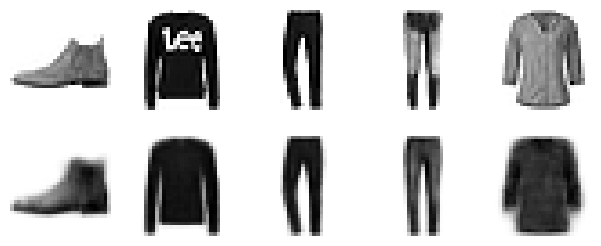

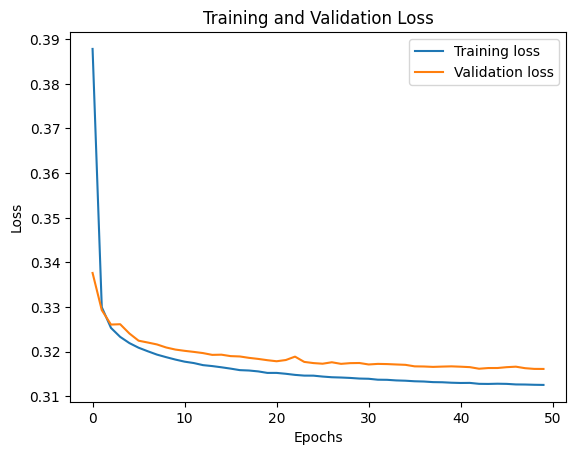

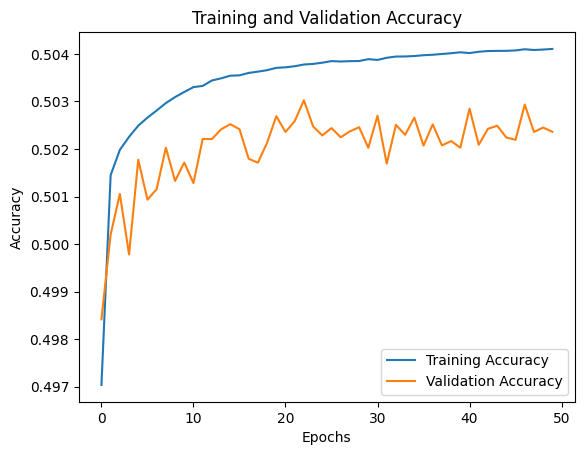

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt

# Cargar la base de datos FASHION MNIST
(x_train, _), (x_test, _) = fashion_mnist.load_data()

# Normalizar los datos a valores en el rango [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Redimensionar los datos a (n_samples, 28, 28, 1)
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Hacer shuffle de los datos de entrenamiento
x_train = np.random.permutation(x_train)

# Parámetros del modelo
latent_dim = 3 # Dimensionalidad del espacio latente
input_shape = (28, 28, 1)  # Forma de la entrada

# Definición del encoder
def build_encoder(input_shape, latent_dim):
    encoder_inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
    x = tf.keras.layers.BatchNormalization()(x)  # Aplicación de Batch Normalization
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Aplicación de Batch Normalization
    x = tf.keras.layers.Flatten()(x)

    # Agregando las capas densas adicionales
    x = tf.keras.layers.Dense(128, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)
    x = tf.keras.layers.Dense(64, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(3))(x)

    x = tf.keras.layers.Dense(16, activation='relu')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    return models.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

encoder = build_encoder(input_shape, latent_dim)
encoder.summary()

# Definición del decoder
def build_decoder(latent_dim):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((7, 7, 64))(x)
    x = layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)
    return models.Model(latent_inputs, outputs, name='decoder')

decoder = build_decoder(latent_dim)
decoder.summary()

# Definición del VAE (Variational Autoencoder)
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        self.add_loss(K.mean(kl_loss) / 784.0)
        return reconstructed

# Crear una métrica personalizada de accuracy
def vae_accuracy(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return K.mean(K.equal(y_true, K.round(y_pred)))

# Crear una instancia del modelo VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer='adam', loss='binary_crossentropy', metrics=[vae_accuracy])

# Entrenamiento del VAE
history = vae.fit(x_train, x_train, epochs=50, batch_size=128, validation_data=(x_test, x_test))

# Función para graficar y mostrar las reconstrucciones
def plot_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        # Imágenes originales
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index].reshape(28, 28), cmap="binary")
        plt.axis("off")
        # Imágenes reconstruidas
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index].reshape(28, 28), cmap="binary")
        plt.axis("off")
    plt.show()

# Usar la función con tu modelo y datos
plot_reconstructions(vae, x_test, n_images=5)

# Gráficas de pérdida y precisión
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['vae_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_vae_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
